# The Sorting Hat 
The sorting hat assigns new witches and wizards into the houses that they will join for the remainder of their stay at Hogwarts. ![Sorting Hat](https://vignette.wikia.nocookie.net/harrypotter/images/6/62/Sorting_Hat.png/revision/latest?cb=20161120072849)Presumably, the Hat uses some **prior knowledge** to inform its decision of where a student will best fit in. From a Machine Learning perspective we could view this process as a **classification** task: given some **labeled** data (for example, information about previous Hogwarts students (the **data**) and which house they belonged to (the **label/class**)) can we build a model that can **predict** which house a new student belongs to. 

### In order to understand the magical ways of the Hat, we will perform the following:
1. Generate a dataset *...mmhhm...* I mean survey some previous Hogwarts students
2. Do some basic visualization to investigate how our features separate the classes
3. Teach a machine learning model about previous students
4. Predict your house and visualize where you stand relative to past students!

In an attempt to organize things a bit, I've put some functions in a script called [sortinghat_functions.py](https://github.com/michaelsilverstein/TheSortingHat/blob/master/sortinghat_functions.py)

# (1) Generate dataset
The Sorting Hat itself has been endowed with years upon years of knowledge about different students. Unforunately the Hat wasn't available to send me all of its data, so we will have to generate it ourself. In my opinion, generating datasets is a valuable exercise in and of itself. A machine learning dataset consists of a few components: **samples** (in this case, students), **features** (measured characteristics), and **class labels** (in this case, the house each student belonged to). In general, a machine learning **training set** (the dataset which contains previous measurements we wish to learn from), looks like this:

| Sample | Feature 1 | $\cdot\cdot\cdot$ | Feature N | Class |
| --- | --- | --- | --- | --- |
| Sample$_1$ | Observation$_{1,1}$ | $\cdot\cdot\cdot$ | Observation$_{1,N}$ | Class$_1$ |
|  $\cdot\cdot\cdot$ |  $\cdot\cdot\cdot$ | $\cdot\cdot\cdot$ | $\cdot\cdot\cdot$| $\cdot\cdot\cdot$ |
| Sample$_M$ | Observation$_{M,1}$ | $\cdot\cdot\cdot$ | Observation$_{M,N}$ | Class$_M$ |

Now, we have to imagine that the Sorting Hat has gathered information on all sorts of features, some of which will have more discriminatory power than others. For example, below is the height distribution of the students from each house. 
```python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sortinghat_functions as sh
"""Generate height example"""
# List houses
houses = ['Gryffindor', 'Hufflepuff', 'Ravenclaw', 'Slytherin']
palette = dict(zip(houses, ['red', 'gold', 'lightblue', 'green']))

# Assume same mean height, standard deviation, and class size for each house
mean_height = 5*12+7/12
std = 5
n = 20
# The seed for a random process establishes where the process "starts from". This allows us to 
# reproduce any random process, like sampling, which is used to generate the data
random_seed = 123

df = sh.generate_feature(mean_height, std, n, houses, 'height', random_seed)
g = sns.FacetGrid(df, hue='class', aspect=2.5, palette=palette)
g.map(sns.kdeplot, 'height', shade=True).add_legend(title='House')
plt.xlabel('Height (in)')
plt.yticks([])
plt.show()
```
![Height distribution](figures/height_dist.png) 

As we can see it doesn't seem like this feature (height) does not provide much discriminatory power between the different classes (as in, if all we knew about the students was their height we would have very little ability to distinguish which ones belonged to which house). Below we will generate data for some more features we believe the Hat may have observed.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sortinghat_functions as sh

houses = ['Gryffindor', 'Hufflepuff', 'Ravenclaw', 'Slytherin']
palette = dict(zip(houses, ['red', 'gold', 'lightblue', 'green']))

"""Let's generate data for some features!"""
# Choose features
features = ['height', 'bravery', 'criticality', 'Canadianness', 'scholar', 'kindness']
# Choose mean value for each feature (and for each house)
# Order maintained by `houses`
# `sh.generate_feature()` will apply single value to all classes if only one value passed
means = [5*12+7/12, [.8, .3, .4, .6], [.6, .4, .9, .4], [.3, .9, .5, .1], [.7, .6, .8, .6], [.7, .9, .6, .2]]
stds = [5, .2, [.3, .3, .3, .4], [.4, .5, .5, .3], .2, .2]
n = 20
random_seed = 123

# Generate data for each feature and save to a single dataframe
df = pd.DataFrame()
for feature, ms, ss in zip(features, means, stds):
    # We want all features (except height) to exist on a scale 0-1
    if feature != 'height':
        MIN, MAX = 0, 1
    else:
        MIN, MAX = None, None
    # Use the function that I wrote in `sortinghat_functions.py` to generate data for each feature for all classes
    data = sh.generate_feature(ms, ss, n, houses, feature, random_seed, MIN, MAX)
    
    if df.empty:
        df = data
    else:
        df = df.join(data[feature])
    # Change random seed so next sampling of next feature is independent
    random_seed += 1
# Place class label as last feature
df = df[[c for c in df if c!='class']+['class']]
# Let's rescale `height` between 0 and 1 so we can easily compare with other features
df['height'] = sh.rescale(df.height)
# Melt || Feat 1 | ... | Feat N | class || -> || feature | value | class ||
melted = df.melt('class', var_name='feature')
df.head()

,height,bravery,criticality,Canadianness,scholar,kindness,class
0,0.329989,0.857696,0.390349,0.035078,0.585638,0.620000,Gryffindor
1,0.731259,0.707409,0.603187,0.861147,0.705925,0.823835,Gryffindor
2,0.593642,0.532399,0.315964,0.064000,0.812518,0.839669,Gryffindor
3,0.248951,1.000000,0.698619,0.341979,0.570470,0.449344,Gryffindor
4,0.427665,0.506525,0.694519,0.332164,0.530913,0.791825,Gryffindor


# (2) Data visualization
Our features may capture differences independently, but likely there are higher order relationships that distinguish even better (interactions between multiple features that separate classes). What makes a Gryffindor? Is it someone who is brave or smart? Or someone who is brave **AND** smart, etc. Let's take a look at some pairwise interactions that exist in our data.

## Visualize pairwise interactions

C:\Users\Michael\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


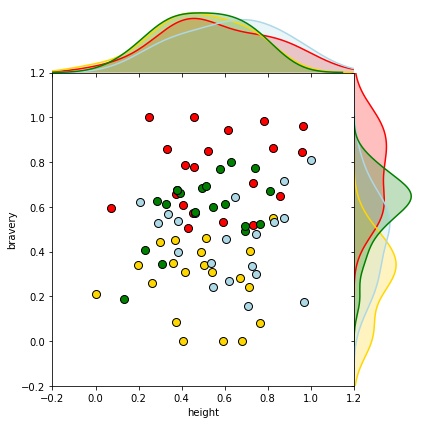

In [9]:
"""Visualize pairwise interaction of features `height` and `bravery`"""
x, y = 'height', 'bravery'
g = sns.JointGrid(x, y, df, space=0, xlim=(-.2, 1.2), ylim=(-.2, 1.2))
for house, house_data in df.groupby('class'):
    c = palette[house]
    sns.kdeplot(house_data[x], ax=g.ax_marg_x, legend=False, shade=True, color=c)
    sns.kdeplot(house_data[y], ax=g.ax_marg_y, vertical=True, legend=False,shade=True, color=c)
    g.ax_joint.plot(house_data[x], house_data[y], 'o', color=c, markeredgecolor='k', ms=8)
# plt.savefig('figures/height-vs-bravery')

### `height` feature has lower discriminatory power
Not suprisingly, we do not gain much discriminatory power from our `height` feature. As can be seen above, most of the variability in our classes is contributed from the `bravery` feature. The distinctions aren't completely clear, but if you were to separate the data by class, you'd do so with mostly horizontal lines (no discrimination would come from drawing vertical lines).

Next, let's look at the pairwise interactions amongst all of our features.

C:\Users\Michael\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


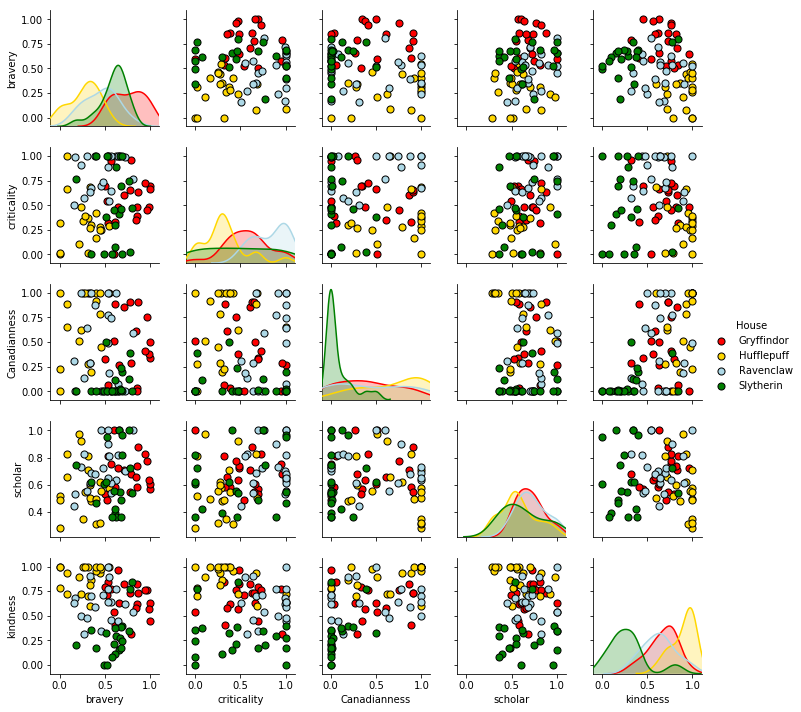

In [15]:
"""Visualize pairwise interactions amongst all features"""
# First, let's exclude `height` since we already know that it is not a very useful feature
data = df[[c for c in df if c!='height']]
g = sns.PairGrid(data, 'class', palette=palette, height=2)
g.map_diag(sns.kdeplot, shade=True)
g.map_offdiag(plt.scatter, s=50, edgecolor='k')
g.set(xlim=(-.1,1.1))
g.add_legend(title='House')
# plt.savefig('figures/feature-pairs')
plt.show()

### Ok, well that's overwhelming
This is a lot to take in... let's take a step back and just look at the individual feature distributions for each class

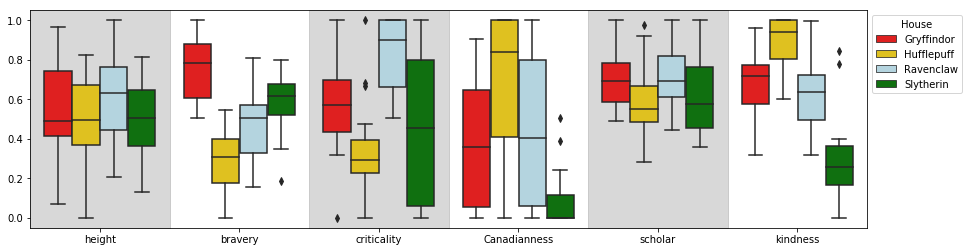

In [2]:
"""Visualize single features"""
# Set figure size
plt.figure(figsize=(15,4))
# Plot a boxplot of each feature colored by house (class)
sns.boxplot('feature', 'value', 'class', melted, palette=palette)
# Stripe every other feature for easier visualization
sh.zebra()
# Move legend to outside top right corner
plt.legend(bbox_to_anchor=(1,1), title='House')
# Turn off x and y labels
plt.ylabel('')
plt.xlabel('')
# plt.savefig('figures/boxplots', bbox_inches='tight')
plt.show()

### Ok that seems pretty valuable
Looking at the data this way can give us a sense of the overall differences between the trends in classes, but we have now lost the higher-order interactions between this features. What makes a student a member of one house versus another is the *combination* of their attributes. 

We represent each of these features in their own dimension in space. Above when we looked at the pairwise interactions, we were looking at two dimensions at a time, and while we can't visualize it, this data actually exists in 6 dimensions! Let's try to get a rough gauge of the overall distance between our students using dimensionality reduction with PCA.

Very briefly, Prinicipal Coordinate Analysis performs an eigenvalue decomposisition of the covariance matrix of your data... This sounds kind of crazy, but essentially it takes the covariance matrix (how each student co-varies with each other student over the measurement of each features) and finds the axes of maximum variation. The top two of these prinical components explain will capture the most variability in two dimensions - this allows us to visualize high-dimensional data while preserving the variability between our samples.

In [39]:
"""Perform Prinicipal Coordinate Analysis"""
from sklearn.decomposition import PCA

# Create a PCA object from sklearn and provide a random state
pca = PCA(random_state=123)
# We only want to pass our actual data, not the class labels
data = df[[c for c in df if c!='class']]

# Apply PCA transformation and take top two components
pca_data = pca.fit_transform(data)[:, :2]

# Place PCA data into a dataframe and add class labels
# The order of the data is preserved from how we inputted it
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
pca_df['class'] = df['class']
# Extract the explained variance by each component (how much of the total variability in space is captured by each component)
explained_var = pca.explained_variance_ratio_
pca_df.head()

,PC1,PC2,class
0,-0.353180,0.205696,Gryffindor
1,0.436454,-0.198377,Gryffindor
2,-0.168385,0.278495,Gryffindor
3,-0.238924,-0.180697,Gryffindor
4,0.017449,-0.060001,Gryffindor


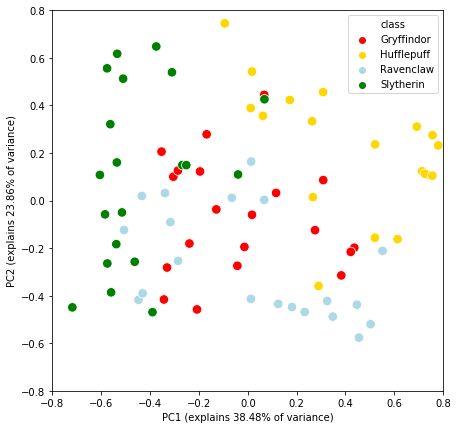

In [95]:
# Visualize PCA
plt.figure(figsize=(7,7))
sns.scatterplot('PC1', 'PC2', 'class', data=pca_df, s=90, palette=palette)
plt.xlabel(f'PC1 (explains {explained_var[0]*100:.2f}% of variance)')
plt.ylabel(f'PC2 (explains {explained_var[1]*100:.2f}% of variance)')
plt.legend(bbox_to_anchor=(1,1))
plt.ylim(-.8, .8)
plt.xlim(-.8, .8)
plt.savefig('figures/PCA', bbox_inches='tight')
plt.show()

### 60% of the variability in our data is on display
Our data lives in six dimensional space and in the graphic above we have captured about 60% of the variability that exits that space. There are many reasons why we should only take insight from PCA with a grain of salt, but it can certainly be valuable for more qualitative conclusions. It seems like Hufflepuffs are the most different from the other houses, followed by Slytherin. Ravenclaws and Gryffindors seem to be most similar, with some Slytherins and Gryffindors appearing very similar (mhm, Harry?).

# (3) Machine Learning
We can continue to dive further and further into two dimensional representations of our data to gain some mostly qualitative insight and we can even start to perform some statistics on which features separate our classes the most. These are all very valuable and cool. 

But I'm the Sorting Hat. I need to **predict** which House each student belongs. I will do this using my brain aka a **neural network**. Neural networks perform a very complicated task that is actually quite intuitive - the idea is loosely based off our understanding of how animal brains work. Neural networks take in observations from an assortment of features and learn about abstracted interactions between these features that are useful for distinguishing different classes. Each of these abstracted interactions is called a **neuron** and is supposed to be symbolic of the neurons in our brain - each of which will individually fire upon receving some combination of input. 

TODO: NEED TO MAKE THIS MORE CLEAR

The network learns what interactions are relevant by... guessing. It starts off by guessing with total randomness which set of interactions of features will produce meaningful neurons and then tries to make predictions. The network then compares its predictions to the truth and adjusts the features mixtures until its predictions become more accurate.

In general, classifcation machine learning algorithms work by using a fraction of the data to train on and then another fraction to test on. The **training set** is used to teach the classifier (THE HAT!) and then the **test set** is used to validate how accurate these predictions are. There are many **hyerparameters** that we can set that will change the nature of how the classifier operates and wow I cannot describe all of this right now, please come talk to me some time if you are interested.

# Plot decision boundary on PCA
This is just for visualizing decision boundary (for actually ML we will train on the actual features (bravery, kindness, etc.))

In [41]:
"""Train the Hat"""
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

# Split data into training and testing
X = pca_df[[c for c in pca_df if c not in ['class', 'height']]]
y = pca_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=123, stratify=y)

# Train
pca_nn = MLPClassifier(20, learning_rate_init=.1)
pca_nn.fit(X_train, y_train)

# Test
y_hat = pca_nn.predict(X_test)

# Calculate accuracy
acc = (y_hat == y_test)
acc.sum()/len(acc)

/Users/michaelsilverstein/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.75

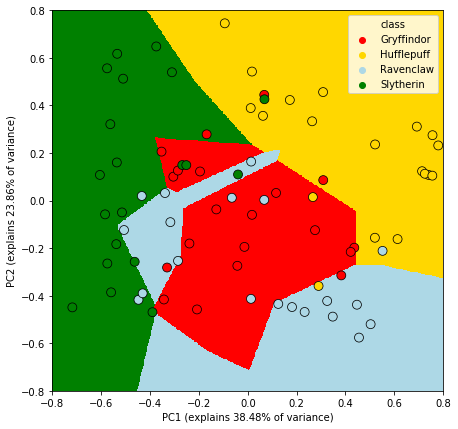

In [19]:
"""Predict points within the .8x.8 grid that PCA is in """
from matplotlib.colors import ListedColormap
# Generate mesh 
grid_lim = np.linspace(-.8, .8, 500)
xx, yy = np.meshgrid(grid_lim, grid_lim)
grid = np.hstack([xx.reshape(-1,1), yy.reshape(-1,1)])
# Predict mesh
y_hats = nn.predict(grid).reshape(xx.shape)
enum = {h:i for i,h in enumerate(houses)}
y_hats = pd.DataFrame(y_hats).applymap(lambda x: enum[x])

plt.figure(figsize=(7,7))
plt.pcolormesh(xx, yy, y_hats, cmap=ListedColormap([palette[h] for h in houses]))
sns.scatterplot('PC1', 'PC2', 'class', data=pca_df, s=80, palette=palette, edgecolor='k')
plt.ylim(-.8, .8)
plt.xlim(-.8, .8)
plt.xlabel(f'PC1 (explains {explained_var[0]*100:.2f}% of variance)')
plt.ylabel(f'PC2 (explains {explained_var[1]*100:.2f}% of variance)')
# plt.savefig('figures/pca_learned')
plt.show()

# Train real NN (on real features, not PC)

In [43]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Split data into training and testing
X = df[[c for c in df if c not in ['class', 'height']]]
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=123, stratify=y)

# Train
nn = MLPClassifier(50, learning_rate_init=.001)
nn.fit(X_train, y_train)

# Test
y_hat = nn.predict(X_test)

# Calculate accuracy
acc = (y_hat == y_test)
acc.sum()/len(acc)

/Users/michaelsilverstein/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/michaelsilverstein/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.75

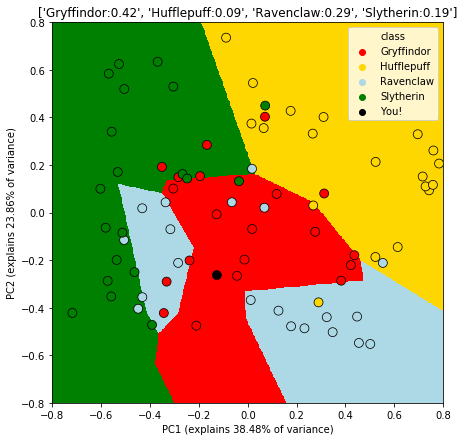

In [110]:
bravery = .7
criticality = .8
Canadian = .2
scholar = 1
kind = .9

# Predict class probs
individ = pd.DataFrame([[bravery, criticality, Canadian, scholar, kind]], columns=X_test.columns)
class_probs = [':'.join([c, f'{p:.2f}']) for c, p in zip(nn.classes_, nn.predict_proba(individ)[0])]

"""# Plot PCA with probs"""
individ_ = individ.copy()
individ_['class'] = 'You!'
new_df = pd.concat([df, individ_]).reset_index(drop=True)

# Create a PCA object from sklearn and provide a random state
pca = PCA(random_state=123)
# We only want to pass our actual data, not the class labels
data = new_df[[c for c in df if c not in ['class', 'height']]]

# Apply PCA transformation and take top two components
pca_data = pca.fit_transform(data)[:, :2]

# Place PCA data into a dataframe and add class labels
# The order of the data is preserved from how we inputted it
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
pca_df['class'] = new_df['class']

# Plot# 
#Generate mesh 
grid_lim = np.linspace(-.8, .8, 500)
xx, yy = np.meshgrid(grid_lim, grid_lim)
grid = np.hstack([xx.reshape(-1,1), yy.reshape(-1,1)])
# Predict mesh
y_hats = pca_nn.predict(grid).reshape(xx.shape)
enum = {h:i for i,h in enumerate(houses)}
y_hats = pd.DataFrame(y_hats).applymap(lambda x: enum[x])

plt.figure(figsize=(7,7))
plt.pcolormesh(xx, yy, y_hats, cmap=ListedColormap([palette[h] for h in houses]))
palette['You!'] = 'k'
sns.scatterplot('PC1', 'PC2', 'class', data=pca_df, s=80, palette=palette, edgecolor='k')
plt.ylim(-.8, .8)
plt.xlim(-.8, .8)
plt.xlabel(f'PC1 (explains {explained_var[0]*100:.2f}% of variance)')
plt.ylabel(f'PC2 (explains {explained_var[1]*100:.2f}% of variance)')
plt.title(class_probs)
plt.show()